<a href="https://colab.research.google.com/github/luiseduaardo/NeuroPrev/blob/main/treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install optuna

In [8]:
import pandas as pd
import numpy as np
import joblib
import os
import optuna
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score

In [9]:
df = pd.read_csv('dataset/healthcare-dataset-stroke-data.csv')


In [10]:
df = df.drop('id', axis = 1) #remove coluna id

#separacao do target
X = df.drop("stroke", axis=1)
y = df["stroke"]


#split treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=6,
    stratify=y
)

#imputacao da mediana do bmi no treino
median_bmi = x_treino["bmi"].median()

x_treino["bmi"] = x_treino["bmi"].fillna(median_bmi)
x_teste["bmi"] = x_teste["bmi"].fillna(median_bmi)


In [11]:
#one hot encoding
x_treino = pd.get_dummies(x_treino)
x_teste = pd.get_dummies(x_teste)

In [12]:
#alinhar colunas
x_treino, x_teste = x_treino.align(x_teste, join="left", axis=1, fill_value=0)

#XGBOOST

In [13]:
#calculo do scale pos weight
negativos = (y_treino == 0).sum()
positivos = (y_treino == 1).sum()

scale_pos_weight = negativos / positivos
scale_pos_weight


np.float64(19.542713567839197)

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

modelo_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=6,
    eval_metric='logloss'
)

modelo_xgb.fit(x_treino, y_treino)

y_pred = modelo_xgb.predict(x_teste)

print("Accuracy:", accuracy_score(y_teste, y_pred))
print("\nRelatório:\n", classification_report(y_teste, y_pred))

Accuracy: 0.8463796477495108

Relatório:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       972
           1       0.17      0.54      0.26        50

    accuracy                           0.85      1022
   macro avg       0.57      0.70      0.59      1022
weighted avg       0.93      0.85      0.88      1022



In [15]:
#thrershold exploratorio
y_prob = modelo_xgb.predict_proba(x_teste)[:, 1]

import numpy as np
from sklearn.metrics import classification_report

for t in [0.2, 0.3, 0.4, 0.5]:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_teste, y_pred_t))



Threshold = 0.2
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.80      0.21        50

    accuracy                           0.70      1022
   macro avg       0.55      0.75      0.51      1022
weighted avg       0.94      0.70      0.79      1022


Threshold = 0.3
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.13      0.70      0.22        50

    accuracy                           0.76      1022
   macro avg       0.56      0.73      0.54      1022
weighted avg       0.94      0.76      0.83      1022


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.15      0.64      0.24        50

    accuracy                           0.80      1022
   macro avg       0.56      0.72      0.56      1022
weighted avg       0.94

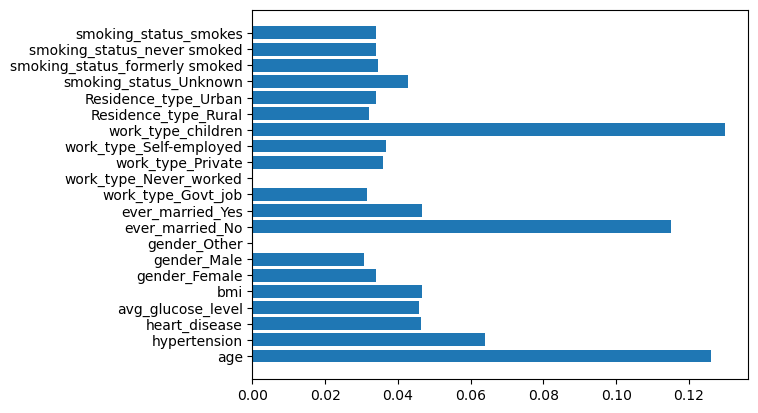

In [16]:
#feature importance
import matplotlib.pyplot as plt

importances = modelo_xgb.feature_importances_
features = x_treino.columns

plt.barh(features, importances)
plt.show()

#XGBOOST com optuna e cross validation


In [19]:
import optuna
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=6
)

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "scale_pos_weight": scale_pos_weight,
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "random_state": 6,         
        "tree_method": "hist"
    }

    scores = []

    for train_idx, val_idx in cv.split(x_treino, y_treino):

        X_train_fold = x_treino.iloc[train_idx]
        y_train_fold = y_treino.iloc[train_idx]

        X_val_fold = x_treino.iloc[val_idx]
        y_val_fold = y_treino.iloc[val_idx]

        model = XGBClassifier(**params)

        model.fit(
            X_train_fold,
            y_train_fold,
            verbose=False
        )

        y_proba = model.predict_proba(X_val_fold)[:, 1]

        score = average_precision_score(y_val_fold, y_proba)
        scores.append(score)

    return np.mean(scores)
#20 trials como sugerido na mentoria
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params


[I 2026-01-29 22:49:25,177] A new study created in memory with name: no-name-831b5e6b-5b50-45b7-a226-b0caaab9809a
[I 2026-01-29 22:49:27,279] Trial 0 finished with value: 0.15845285320950292 and parameters: {'n_estimators': 321, 'max_depth': 7, 'learning_rate': 0.05710432062278572, 'subsample': 0.8064935988850028, 'colsample_bytree': 0.9867326937791189, 'min_child_weight': 7, 'gamma': 4.5572530638069235}. Best is trial 0 with value: 0.15845285320950292.
[I 2026-01-29 22:49:29,371] Trial 1 finished with value: 0.15350287683967861 and parameters: {'n_estimators': 256, 'max_depth': 5, 'learning_rate': 0.11032208028003246, 'subsample': 0.6290774246355807, 'colsample_bytree': 0.8959044305536575, 'min_child_weight': 6, 'gamma': 0.38363925961424683}. Best is trial 0 with value: 0.15845285320950292.
[I 2026-01-29 22:49:32,302] Trial 2 finished with value: 0.1406438258540365 and parameters: {'n_estimators': 588, 'max_depth': 4, 'learning_rate': 0.1835942363987437, 'subsample': 0.645904717100413

In [ ]:
#treino com melhores hiperparametros
best_model = XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,  
    random_state=6,
    tree_method="hist"
)

best_model.fit(x_treino, y_treino)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7280341065593054
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [21]:
from sklearn.metrics import classification_report, roc_auc_score

y_proba_test = best_model.predict_proba(x_teste)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_teste, y_proba_test))
print("\nClassification Report:\n")
print(classification_report(y_teste, y_pred_test))


ROC-AUC: 0.8463477366255144

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       972
           1       0.13      0.84      0.23        50

    accuracy                           0.72      1022
   macro avg       0.56      0.78      0.53      1022
weighted avg       0.95      0.72      0.80      1022



In [22]:
#avaliacao de thershold
y_proba = best_model.predict_proba(x_teste)[:, 1]

import numpy as np
from sklearn.metrics import classification_report

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    print(f"\n===== Threshold = {t} =====")
    print(classification_report(y_teste, y_pred_t))



===== Threshold = 0.2 =====
              precision    recall  f1-score   support

           0       0.99      0.42      0.59       972
           1       0.08      0.94      0.14        50

    accuracy                           0.45      1022
   macro avg       0.53      0.68      0.37      1022
weighted avg       0.95      0.45      0.57      1022


===== Threshold = 0.3 =====
              precision    recall  f1-score   support

           0       0.99      0.53      0.69       972
           1       0.09      0.94      0.17        50

    accuracy                           0.55      1022
   macro avg       0.54      0.74      0.43      1022
weighted avg       0.95      0.55      0.67      1022


===== Threshold = 0.4 =====
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       972
           1       0.11      0.90      0.19        50

    accuracy                           0.63      1022
   macro avg       0.55      0.76      0.

In [23]:
import os
import json
import joblib

# ===== CONFIGURAÇÕES FINAIS =====
THRESHOLD_FINAL = 0.4  # thrershold escolhido depois do classification report

# pasta de pesos
os.makedirs("weights", exist_ok=True)

# salvando modelo do xgboost com optuna
joblib.dump(best_model, "weights/xgb_model.pkl")

# ===== 2) SALVAR ARTEFATOS DO PREPROCESS + CONFIG =====
artefatos = {
    "median_bmi": float(median_bmi),
    "threshold": float(THRESHOLD_FINAL),
    "feature_columns": list(x_treino.columns)
}

with open("weights/xgb_artefatos.json", "w") as f:
    json.dump(artefatos, f, indent=2)

print("Modelo salvo em: weights/xgb_model.pkl")
print("Artefatos salvos em: weights/xgb_artefatos.json")
print("Threshold salvo:", THRESHOLD_FINAL)
print("Nº de features:", len(artefatos["feature_columns"]))


Modelo salvo em: weights/xgb_model.pkl
Artefatos salvos em: weights/xgb_artefatos.json
Threshold salvo: 0.4
Nº de features: 21


#RANDOM FOREST


In [33]:
#identificar categorias
categorias = []
for i, col in enumerate(x_treino.columns):
    if x_treino[col].nunique() <= 2: #se a coluna for binaria ou for int
        categorias.append(i)

smotenc = SMOTENC(categorical_features = categorias, random_state = 6) #não quebra os valores de categorias
x_treino_blc, y_treino_blc = smotenc.fit_resample(x_treino, y_treino)

In [ ]:
#teste com optuna

def objetivo(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500), #num arvores
        'max_depth': trial.suggest_int('max_depth', 5, 30), #profundidade max
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15), #min de exemplos pra dividir um nó
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), #min de exemplos numa folha
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': 'balanced', #fixo para ajudar no desbalanceamento
        'random_state': 6,
        'n_jobs': -1
    }

    #cria e treina modelo
    modelo = RandomForestClassifier(**params)
    modelo.fit(x_treino_blc, y_treino_blc)

    preds = modelo.predict(x_teste) #testa
    return f1_score(y_teste, preds, pos_label=1)

#estudo e otimização
estudo_rf = optuna.create_study(direction = 'maximize')
estudo_rf.optimize(objetivo, n_trials = 100)

[I 2026-01-29 22:29:45,289] A new study created in memory with name: no-name-86934374-1c28-4461-8d1f-ca6b81a2cee2
[I 2026-01-29 22:29:47,404] Trial 0 finished with value: 0.26153846153846155 and parameters: {'n_estimators': 269, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.26153846153846155.
[I 2026-01-29 22:29:49,618] Trial 1 finished with value: 0.22988505747126436 and parameters: {'n_estimators': 464, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.26153846153846155.
[I 2026-01-29 22:29:50,903] Trial 2 finished with value: 0.2549019607843137 and parameters: {'n_estimators': 153, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.26153846153846155.
[I 2026-01-29 22:29:54,891] Trial 3 finished with value: 0.2125 and parameters: {'n_estimators': 406, 'max_depth': 28, 'min_samples_split': 3,

In [ ]:
#pegando os melhores parâmetros do Optuna
melhores_params = estudo_rf.best_params
melhores_params['class_weight'] = 'balanced'
melhores_params['random_state'] = 6
melhores_params['n_jobs'] = -1

#treina modelo final
modelo_final = RandomForestClassifier(**melhores_params)
modelo_final.fit(x_treino_blc, y_treino_blc)

#salvando os pesos do treinamento
if not os.path.exists('weights'):
    os.makedirs('weights')

joblib.dump(modelo_final, 'weights/modelo_avc_final.pkl')
print("Sucesso! Modelo salvo em weights/modelo_avc_final.pkl")